In [1]:
import pandas as pd
import numpy as np
# from bert_serving.client import BertClient
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score
from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import gc
from os import listdir
import re
import fasttext
import unicodedata
import io
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import pickle
from nltk.corpus import stopwords
import warnings
# import optuna
# import multiprocessing

Using TensorFlow backend.


In [2]:
def set_momentum(optimizer, mom_val):
    """
    Helper to set momentum of Keras optimizers.
    :param optimizer: Keras optimizer
    :param mom_val: value of momentum.
    """
    keys = dir(optimizer)
    if "momentum" in keys:
        tf.keras.backend.set_value(optimizer.momentum, mom_val)
    if "rho" in keys:
        tf.keras.backend.set_value(optimizer.rho, mom_val)
    if "beta_1" in keys:
        tf.keras.backend.set_value(optimizer.beta_1, mom_val)


def set_lr(optimizer, lr):
    """
    Helper to set learning rate of Keras optimizers.
    :param optimizer: Keras optimizer
    :param lr: value of learning rate.
    """
    tf.keras.backend.set_value(optimizer.lr, lr)

class OneCycle(tf.keras.callbacks.Callback):
    """
    A callback class for one-cycle policy training.
    :param lr_range: a tuple of starting (usually minimum) lr value and maximum (peak) lr value.
    :param momentum_range: a tuple of momentum values.
    :param phase_one_fraction: a fraction for phase I (increasing lr) in one cycle. Must between 0 to 1.
    :param reset_on_train_begin: True or False to reset counters when training begins.
    :param record_frq: integer > 0, a frequency in batches to record training loss.
    :param verbose: True or False to print progress.
    """

    def __init__(
            self,
            lr_range,
            momentum_range=None,
            phase_one_fraction=0.3,
            reset_on_train_begin=True,
            record_frq=10,
            verbose=False):

        super(OneCycle, self).__init__()

        self.lr_range = lr_range

        self.momentum_range = momentum_range
        if momentum_range is not None:
            err_msg = "momentum_range must be a 2-numeric tuple (m1, m2)."
            if not isinstance(momentum_range, (tuple,)) or len(momentum_range) != 2:
                raise ValueError(err_msg)

        self.phase_one_fraction = phase_one_fraction
        self.reset_on_train_begin = reset_on_train_begin
        self.record_frq = record_frq
        self.verbose = verbose

        # helper tracker
        self.log = {}  # history in iterations
        self.log_ep = {}  # history in epochs
        self.stop_training = False

        # counter
        self.current_iter = 0

    def get_current_lr(self, n_iter=None):
        """
        A helper function to calculate a current learning rate based on current iteration number.
        :return lr: a current learning rate.
        """
        if n_iter is None:
            n_iter = self.n_iter

        x = float(self.current_iter) / n_iter
        if x < self.phase_one_fraction:
            amp = self.lr_range[1] - self.lr_range[0]
            lr = (np.cos(x * np.pi/self.phase_one_fraction - np.pi) + 1) * amp / 2.0 + self.lr_range[0]
        if x >= self.phase_one_fraction:
            amp = self.lr_range[1]
            lr = (np.cos((x - self.phase_one_fraction) * np.pi/ (1-self.phase_one_fraction)) + 1) / 2.0 * amp
        return lr

    def get_current_momentum(self, n_iter=None):
        """
        A helper function to calculate a current momentum based on current iteration number.
        :return momentum: a current momentum.
        """
        if n_iter is None:
            n_iter = self.n_iter
        amp = self.momentum_range[1] - self.momentum_range[0]
        # delta = (1 - np.abs(np.mod(self.current_iter, n_iter) * 2.0 / n_iter - 1)) * amplitude
        x = float(self.current_iter) / n_iter
        if x < self.phase_one_fraction:
            delta = (np.cos(x * np.pi / self.phase_one_fraction - np.pi) + 1) * amp / 2.0
        if x >= self.phase_one_fraction:
            delta = (np.cos((x - self.phase_one_fraction) * np.pi / (1 - self.phase_one_fraction)) + 1) / 2.0 * amp
        return delta + self.momentum_range[0]


    @property
    def cycle_momentum(self):
        return self.momentum_range is not None

    def on_train_begin(self, logs={}):
        self.n_epoch = self.params['epochs']

        # find number of batches per epoch
        if self.params['batch_size'] is not None:  # model.fit
            self.n_bpe = int(np.ceil(self.params['samples'] / self.params['batch_size']))
        if self.params['batch_size'] is None:  # model.fit_generator
            self.n_bpe = self.params['samples']

        self.n_iter = self.n_epoch * self.n_bpe
        # this is a number of iteration in one cycle

        self.current_iter = 0

    def on_train_batch_begin(self, batch, logs={}):
        set_lr(self.model.optimizer, self.get_current_lr())
        if self.cycle_momentum:
            set_momentum(self.model.optimizer, self.get_current_momentum())

    def on_train_batch_end(self, batch, logs={}):

        if self.verbose:
            print("lr={:.2e}".format(self.get_current_lr()), ",", "m={:.2e}".format(self.get_current_momentum()))

        # record according to record_frq
        if np.mod(int(self.current_iter), self.record_frq) == 0:
            self.log.setdefault('lr', []).append(self.get_current_lr())
            if self.cycle_momentum:
                self.log.setdefault('momentum', []).append(self.get_current_momentum())

            for k, v in logs.items():
                self.log.setdefault(k, []).append(v)

            self.log.setdefault('iter', []).append(self.current_iter)

        # update current iteration
        self.current_iter += 1

        # consider termination
        if self.current_iter == self.n_iter:
            self.stop_training = True

    def on_epoch_end(self, epoch, logs={}):
        self.log_ep.setdefault('epoch', []).append(epoch)
        self.log_ep.setdefault('lr', []).append(
            tf.keras.backend.get_value(self.model.optimizer.lr))

        for k, v in logs.items():
            self.log_ep.setdefault(k, []).append(v)

    def test_run(self, n_iter=None):
        """
        Visualize values of learning rate (and momentum) as a function of iteration (batch).
        :param n_iter: a number of cycles. If None, 1000 is used.
        """

        if hasattr(self, 'current_iter'):
            original_it = self.current_iter

        if n_iter is None:
            if hasattr(self, 'n_iter'):
                n_iter = self.n_iter
            else:
                n_iter = 1000
        n_iter = int(n_iter)

        lrs = np.zeros(shape=(n_iter,))
        if self.momentum_range is not None:
            moms = np.zeros_like(lrs)

        for i in range(int(n_iter)):
            self.current_iter = i
            lrs[i] = self.get_current_lr(n_iter)
            if self.cycle_momentum:
                moms[i] = self.get_current_momentum(n_iter)
        if not self.cycle_momentum:
            plt.plot(lrs)
            plt.xlabel('iterations')
            plt.ylabel('lr')
        else:
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.plot(lrs)
            plt.xlabel('iterations')
            plt.ylabel('lr')
            plt.subplot(1, 2, 2)
            plt.plot(moms)
            plt.xlabel('iterations')
            plt.ylabel('momentum')

        if hasattr(self, 'current_iter'):
            self.current_iter = original_it

In [3]:
# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function

# class Lookahead(OptimizerV2):
#     """This class allows to extend optimizers with the lookahead mechanism.

#     The mechanism is proposed by Michael R. Zhang et.al in the paper
#     [Lookahead Optimizer: k steps forward, 1 step back]
#     (https://arxiv.org/abs/1907.08610v1). The optimizer iteratively updates two
#     sets of weights: the search directions for weights are chosen by the inner
#     optimizer, while the "slow weights" are updated each `k` steps based on the
#     directions of the "fast weights" and the two sets of weights are
#     synchronized. This method improves the learning stability and lowers the
#     variance of its inner optimizer.

#     Example of usage:

#     ```python
#     opt = tf.keras.optimizers.SGD(learning_rate)
#     opt = tfa.optimizers.Lookahead(opt)
#     ```
#     """

#     def __init__(self,
#                  optimizer,
#                  sync_period=6,
#                  slow_step_size=0.5,
#                  name="Lookahead",
#                  **kwargs):
#         r"""Wrap optimizer with the lookahead mechanism.

#         Args:
#             optimizer: The original optimizer that will be used to compute
#                 and apply the gradients.
#             sync_period: An integer. The synchronization period of lookahead.
#                 Enable lookahead mechanism by setting it with a positive value.
#             slow_step_size: A floating point value.
#                 The ratio for updating the slow weights.
#             name: Optional name for the operations created when applying
#                 gradients. Defaults to "Lookahead".
#             **kwargs: keyword arguments. Allowed to be {`clipnorm`,
#                 `clipvalue`, `lr`, `decay`}. `clipnorm` is clip gradients
#                 by norm; `clipvalue` is clip gradients by value, `decay` is
#                 included for backward compatibility to allow time inverse
#                 decay of learning rate. `lr` is included for backward
#                 compatibility, recommended to use `learning_rate` instead.
#         """
#         super(Lookahead, self).__init__(name, **kwargs)

#         if isinstance(optimizer, str):
#             optimizer = tf.keras.optimizers.get(optimizer)
#         if not isinstance(optimizer, tf.keras.optimizers.Optimizer):
#             raise TypeError(
#                 "optimizer is not an object of tf.keras.optimizers.Optimizer")

#         self._optimizer = optimizer
#         self._set_hyper('sync_period', sync_period)
#         self._set_hyper('slow_step_size', slow_step_size)
#         self._initialized = False

#     @property
#     def lr(self):
#       return self._optimizer.lr

#     @lr.setter
#     def lr(self, lr):
#       self._optimizer.lr = lr
      
#     def _create_slots(self, var_list):
#         self._optimizer._create_slots(var_list=var_list)  # pylint: disable=protected-access
#         for var in var_list:
#             self.add_slot(var, 'slow')

#     def _create_hypers(self):
#         self._optimizer._create_hypers()  # pylint: disable=protected-access

#     def _prepare(self, var_list):
#         return self._optimizer._prepare(var_list=var_list)  # pylint: disable=protected-access

#     def apply_gradients(self, grads_and_vars, name=None):
#         self._optimizer._iterations = self.iterations  # pylint: disable=protected-access
#         return super(Lookahead, self).apply_gradients(grads_and_vars, name)

#     def _init_op(self, var):
#         slow_var = self.get_slot(var, 'slow')
#         return slow_var.assign(
#             tf.where(
#                 tf.equal(self.iterations,
#                          tf.constant(0, dtype=self.iterations.dtype)),
#                 var,
#                 slow_var,
#             ),
#             use_locking=self._use_locking)

#     def _look_ahead_op(self, var):
#         var_dtype = var.dtype.base_dtype
#         slow_var = self.get_slot(var, 'slow')
#         local_step = tf.cast(self.iterations + 1, tf.dtypes.int64)
#         sync_period = self._get_hyper('sync_period', tf.dtypes.int64)
#         slow_step_size = self._get_hyper('slow_step_size', var_dtype)
#         step_back = slow_var + slow_step_size * (var - slow_var)
#         sync_cond = tf.equal(
#             tf.math.floordiv(local_step, sync_period) * sync_period,
#             local_step)
#         with tf.control_dependencies([step_back]):
#             slow_update = slow_var.assign(
#                 tf.where(
#                     sync_cond,
#                     step_back,
#                     slow_var,
#                 ),
#                 use_locking=self._use_locking)
#             var_update = var.assign(
#                 tf.where(
#                     sync_cond,
#                     step_back,
#                     var,
#                 ),
#                 use_locking=self._use_locking)
#         return tf.group(slow_update, var_update)

#     @property
#     def weights(self):
#         return self._weights + self._optimizer.weights

#     def _resource_apply_dense(self, grad, var):
#         init_op = self._init_op(var)
#         with tf.control_dependencies([init_op]):
#             train_op = self._optimizer._resource_apply_dense(grad, var)  # pylint: disable=protected-access
#             with tf.control_dependencies([train_op]):
#                 look_ahead_op = self._look_ahead_op(var)
#         return tf.group(init_op, train_op, look_ahead_op)

#     def _resource_apply_sparse(self, grad, var, indices):
#         init_op = self._init_op(var)
#         with tf.control_dependencies([init_op]):
#             train_op = self._optimizer._resource_apply_sparse(  # pylint: disable=protected-access
#                 grad, var, indices)
#             with tf.control_dependencies([train_op]):
#                 look_ahead_op = self._look_ahead_op(var)
#         return tf.group(init_op, train_op, look_ahead_op)

#     def get_config(self):
#         config = {
#             'optimizer': tf.keras.optimizers.serialize(self._optimizer),
#             'sync_period': self._serialize_hyperparameter('sync_period'),
#             'slow_step_size': self._serialize_hyperparameter('slow_step_size'),
#         }
#         base_config = super(Lookahead, self).get_config()
#         return dict(list(base_config.items()) + list(config.items()))

#     @classmethod
#     def from_config(cls, config, custom_objects=None):
#         optimizer = tf.keras.optimizers.deserialize(
#             config.pop('optimizer'),
#             custom_objects=custom_objects,
#         )
#         return cls(optimizer, **config)

In [4]:
class LRFinder(tf.keras.callbacks.Callback):
    def __init__(self,
                 num_samples,
                 batch_size,
                 minimum_lr=1e-5,
                 maximum_lr=10.,
                 lr_scale='exp',
                 validation_data=None,
                 validation_sample_rate=5,
                 stopping_criterion_factor=4.,
                 loss_smoothing_beta=0.98,
                 save_dir=None,
                 verbose=True):
        """
        This class uses the Cyclic Learning Rate history to find a
        set of learning rates that can be good initializations for the
        One-Cycle training proposed by Leslie Smith in the paper referenced
        below.

        A port of the Fast.ai implementation for Keras.

        # Note
        This requires that the model be trained for exactly 1 epoch. If the model
        is trained for more epochs, then the metric calculations are only done for
        the first epoch.

        # Interpretation
        Upon visualizing the loss plot, check where the loss starts to increase
        rapidly. Choose a learning rate at somewhat prior to the corresponding
        position in the plot for faster convergence. This will be the maximum_lr lr.
        Choose the max value as this value when passing the `max_val` argument
        to OneCycleLR callback.

        Since the plot is in log-scale, you need to compute 10 ^ (-k) of the x-axis

        # Arguments:
            num_samples: Integer. Number of samples in the dataset.
            batch_size: Integer. Batch size during training.
            minimum_lr: Float. Initial learning rate (and the minimum).
            maximum_lr: Float. Final learning rate (and the maximum).
            lr_scale: Can be one of ['exp', 'linear']. Chooses the type of
                scaling for each update to the learning rate during subsequent
                batches. Choose 'exp' for large range and 'linear' for small range.
            validation_data: Requires the validation dataset as a tuple of
                (X, y) belonging to the validation set. If provided, will use the
                validation set to compute the loss metrics. Else uses the training
                batch loss. Will warn if not provided to alert the user.
            validation_sample_rate: Positive or Negative Integer. Number of batches to sample from the
                validation set per iteration of the LRFinder. Larger number of
                samples will reduce the variance but will take longer time to execute
                per batch.

                If Positive > 0, will sample from the validation dataset
                If Megative, will use the entire dataset
            stopping_criterion_factor: Integer or None. A factor which is used
                to measure large increase in the loss value during training.
                Since callbacks cannot stop training of a model, it will simply
                stop logging the additional values from the epochs after this
                stopping criterion has been met.
                If None, this check will not be performed.
            loss_smoothing_beta: Float. The smoothing factor for the moving
                average of the loss function.
            save_dir: Optional, String. If passed a directory path, the callback
                will save the running loss and learning rates to two separate numpy
                arrays inside this directory. If the directory in this path does not
                exist, they will be created.
            verbose: Whether to print the learning rate after every batch of training.

        # References:
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
        """
        super(LRFinder, self).__init__()

        if lr_scale not in ['exp', 'linear']:
            raise ValueError("`lr_scale` must be one of ['exp', 'linear']")

        if validation_data is not None:
            self.validation_data = validation_data
            self.use_validation_set = True

            if validation_sample_rate > 0 or validation_sample_rate < 0:
                self.validation_sample_rate = validation_sample_rate
            else:
                raise ValueError("`validation_sample_rate` must be a positive or negative integer other than o")
        else:
            self.use_validation_set = False
            self.validation_sample_rate = 0

        self.num_samples = num_samples
        self.batch_size = batch_size
        self.initial_lr = minimum_lr
        self.final_lr = maximum_lr
        self.lr_scale = lr_scale
        self.stopping_criterion_factor = stopping_criterion_factor
        self.loss_smoothing_beta = loss_smoothing_beta
        self.save_dir = save_dir
        self.verbose = verbose

        self.num_batches_ = num_samples // batch_size
        self.current_lr_ = minimum_lr

        if lr_scale == 'exp':
            self.lr_multiplier_ = (maximum_lr / float(minimum_lr)) ** (
                1. / float(self.num_batches_))
        else:
            extra_batch = int((num_samples % batch_size) != 0)
            self.lr_multiplier_ = np.linspace(
                minimum_lr, maximum_lr, num=self.num_batches_ + extra_batch)

        # If negative, use entire validation set
        if self.validation_sample_rate < 0:
            self.validation_sample_rate = self.validation_data[0].shape[0] // batch_size

        self.current_batch_ = 0
        self.current_epoch_ = 0
        self.best_loss_ = 1e6
        self.running_loss_ = 0.

        self.history = {}

    def on_train_begin(self, logs=None):

        self.current_epoch_ = 1
        tf.keras.backend.set_value(self.model.optimizer.lr, self.initial_lr)

        warnings.simplefilter("ignore")

    def on_epoch_begin(self, epoch, logs=None):
        self.current_batch_ = 0

        if self.current_epoch_ > 1:
            warnings.warn(
                "\n\nLearning rate finder should be used only with a single epoch. "
                "Hereafter, the callback will not measure the losses.\n\n")

    def on_batch_begin(self, batch, logs=None):
        self.current_batch_ += 1

    def on_batch_end(self, batch, logs=None):
        if self.current_epoch_ > 1:
            return

        if self.use_validation_set:
            X, Y = self.validation_data[0], self.validation_data[1]

            # use 5 random batches from test set for fast approximate of loss
            num_samples = self.batch_size * self.validation_sample_rate

            if num_samples > X.shape[0]:
                num_samples = X.shape[0]

            idx = np.random.choice(X.shape[0], num_samples, replace=False)
            x = X[idx]
            y = Y[idx]

            values = self.model.evaluate(x, y, batch_size=self.batch_size, verbose=False)
            loss = values[0]
        else:
            loss = logs['loss']

        # smooth the loss value and bias correct
        running_loss = self.loss_smoothing_beta * loss + (
            1. - self.loss_smoothing_beta) * loss
        running_loss = running_loss / (
            1. - self.loss_smoothing_beta**self.current_batch_)

        # stop logging if loss is too large
        if self.current_batch_ > 1 and self.stopping_criterion_factor is not None and (
                running_loss >
                self.stopping_criterion_factor * self.best_loss_):

            if self.verbose:
                print(" - LRFinder: Skipping iteration since loss is %d times as large as best loss (%0.4f)"
                      % (self.stopping_criterion_factor, self.best_loss_))
            return

        if running_loss < self.best_loss_ or self.current_batch_ == 1:
            self.best_loss_ = running_loss

        current_lr = tf.keras.backend.get_value(self.model.optimizer.lr)

        self.history.setdefault('running_loss_', []).append(running_loss)
        if self.lr_scale == 'exp':
            self.history.setdefault('log_lrs', []).append(np.log10(current_lr))
        else:
            self.history.setdefault('log_lrs', []).append(current_lr)

        # compute the lr for the next batch and update the optimizer lr
        if self.lr_scale == 'exp':
            current_lr *= self.lr_multiplier_
        else:
            current_lr = self.lr_multiplier_[self.current_batch_ - 1]

        tf.keras.backend.set_value(self.model.optimizer.lr, current_lr)

        # save the other metrics as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        if self.verbose:
            if self.use_validation_set:
                print(" - LRFinder: val_loss: %1.4f - lr = %1.8f " %
                      (values[0], current_lr))
            else:
                print(" - LRFinder: lr = %1.8f " % current_lr)

    def on_epoch_end(self, epoch, logs=None):
        if self.save_dir is not None and self.current_epoch_ <= 1:
            if not os.path.exists(self.save_dir):
                os.makedirs(self.save_dir)

            losses_path = os.path.join(self.save_dir, 'losses.npy')
            lrs_path = os.path.join(self.save_dir, 'lrs.npy')

            np.save(losses_path, self.losses)
            np.save(lrs_path, self.lrs)

            if self.verbose:
                print("\tLR Finder : Saved the losses and learning rate values in path : {%s}"
                      % (self.save_dir))

        self.current_epoch_ += 1

        warnings.simplefilter("default")

    def plot_schedule(self, clip_beginning=None, clip_endding=None):
        """
        Plots the schedule from the callback itself.

        # Arguments:
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        """
        try:
            import matplotlib.pyplot as plt
            plt.style.use('seaborn-white')
        except ImportError:
            print(
                "Matplotlib not found. Please use `pip install matplotlib` first."
            )
            return

        if clip_beginning is not None and clip_beginning < 0:
            clip_beginning = -clip_beginning

        if clip_endding is not None and clip_endding > 0:
            clip_endding = -clip_endding

        losses = self.losses
        lrs = self.lrs

        if clip_beginning:
            losses = losses[clip_beginning:]
            lrs = lrs[clip_beginning:]

        if clip_endding:
            losses = losses[:clip_endding]
            lrs = lrs[:clip_endding]

        plt.plot(lrs, losses)
        plt.title('Learning rate vs Loss')
        plt.xlabel('learning rate')
        plt.ylabel('loss')
        plt.show()

    @classmethod
    def restore_schedule_from_dir(cls,
                                  directory,
                                  clip_beginning=None,
                                  clip_endding=None):
        """
        Loads the training history from the saved numpy files in the given directory.

        # Arguments:
            directory: String. Path to the directory where the serialized numpy
                arrays of the loss and learning rates are saved.
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.

        Returns:
            tuple of (losses, learning rates)
        """
        if clip_beginning is not None and clip_beginning < 0:
            clip_beginning = -clip_beginning

        if clip_endding is not None and clip_endding > 0:
            clip_endding = -clip_endding

        losses_path = os.path.join(directory, 'losses.npy')
        lrs_path = os.path.join(directory, 'lrs.npy')

        if not os.path.exists(losses_path) or not os.path.exists(lrs_path):
            print("%s and %s could not be found at directory : {%s}" %
                  (losses_path, lrs_path, directory))

            losses = None
            lrs = None

        else:
            losses = np.load(losses_path)
            lrs = np.load(lrs_path)

            if clip_beginning:
                losses = losses[clip_beginning:]
                lrs = lrs[clip_beginning:]

            if clip_endding:
                losses = losses[:clip_endding]
                lrs = lrs[:clip_endding]

        return losses, lrs

    @classmethod
    def plot_schedule_from_file(cls,
                                directory,
                                clip_beginning=None,
                                clip_endding=None):
        """
        Plots the schedule from the saved numpy arrays of the loss and learning
        rate values in the specified directory.

        # Arguments:
            directory: String. Path to the directory where the serialized numpy
                arrays of the loss and learning rates are saved.
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        """
        try:
            import matplotlib.pyplot as plt
            plt.style.use('seaborn-white')
        except ImportError:
            print("Matplotlib not found. Please use `pip install matplotlib` first.")
            return

        losses, lrs = cls.restore_schedule_from_dir(
            directory,
            clip_beginning=clip_beginning,
            clip_endding=clip_endding)

        if losses is None or lrs is None:
            return
        else:
            plt.plot(lrs, losses)
            plt.title('Learning rate vs Loss')
            plt.xlabel('learning rate')
            plt.ylabel('loss')
            plt.show()

    @property
    def lrs(self):
        return np.array(self.history['log_lrs'])

    @property
    def losses(self):
        return np.array(self.history['running_loss_'])

In [5]:
class Lookahead(tf.keras.optimizers.Optimizer):
    """The lookahead mechanism for optimizers.
    Default parameters follow those provided in the original paper.
    # Arguments
        optimizer: An existed optimizer.
        sync_period: int > 0. The synchronization period.
        slow_step: float, 0 < alpha < 1. The step size of slow weights.
    # References
        - [Lookahead Optimizer: k steps forward, 1 step back]
          (https://arxiv.org/pdf/1907.08610v1.pdf)
    """

    def __init__(self, optimizer, sync_period=5, slow_step=0.5, **kwargs):
        super(Lookahead, self).__init__(**kwargs)
        self.optimizer = tf.keras.optimizers.get(optimizer)
        with tf.keras.backend.name_scope(self.__class__.__name__):
            self.sync_period = tf.keras.backend.variable(sync_period, dtype='int64', name='sync_period')
            self.slow_step = tf.keras.backend.variable(slow_step, name='slow_step')

    @property
    def lr(self):
        return self.optimizer.lr

    @lr.setter
    def lr(self, lr):
        self.optimizer.lr = lr

    @property
    def iterations(self):
        return self.optimizer.iterations

    def get_updates(self, loss, params):
        sync_cond = tf.keras.backend.equal((self.iterations + 1) % self.sync_period, 0)
        if True:
            slow_params = [tf.keras.backend.variable(tf.keras.backend.get_value(p), name='sp_{}'.format(i)) for i, p in enumerate(params)]
            self.updates = self.optimizer.get_updates(loss, params)
            slow_updates = []
            for p, sp in zip(params, slow_params):
                sp_t = sp + self.slow_step * (p - sp)
                slow_updates.append(tf.keras.backend.update(sp, tf.keras.backend.switch(
                    sync_cond,
                    sp_t,
                    sp,
                )))
                slow_updates.append(tf.keras.backend.update_add(p, tf.keras.backend.switch(
                    sync_cond,
                    sp_t - p,
                    tf.keras.backend.zeros_like(p),
                )))
        else:
            slow_params = {p.name: tf.keras.backend.variable(tf.keras.backend.get_value(p), name='sp_{}'.format(i)) for i, p in enumerate(params)}
            update_names = ['update', 'update_add', 'update_sub']
            original_updates = [getattr(K, name) for name in update_names]
            setattr(K, 'update', lambda x, new_x: ('update', x, new_x))
            setattr(K, 'update_add', lambda x, new_x: ('update_add', x, new_x))
            setattr(K, 'update_sub', lambda x, new_x: ('update_sub', x, new_x))
            self.updates = self.optimizer.get_updates(loss, params)
            for name, original_update in zip(update_names, original_updates):
                setattr(K, name, original_update)
            slow_updates = []
            for i, update in enumerate(self.updates):
                if isinstance(update, tuple):
                    name, x, new_x, adjusted = update + (update[-1],)
                    update_func = getattr(K, name)
                    if name == 'update_add':
                        adjusted = x + new_x
                    if name == 'update_sub':
                        adjusted = x - new_x
                    if x.name not in slow_params:
                        self.updates[i] = update_func(x, new_x)
                    else:
                        slow_param = slow_params[x.name]
                        slow_param_t = slow_param + self.slow_step * (adjusted - slow_param)
                        slow_updates.append(tf.keras.backend.update(slow_param, tf.keras.backend.switch(
                            sync_cond,
                            slow_param_t,
                            slow_param,
                        )))
                        self.updates[i] = tf.keras.backend.update(x, tf.keras.backend.switch(
                            sync_cond,
                            slow_param_t,
                            adjusted,
                        ))
            slow_params = list(slow_params.values())
        self.updates += slow_updates
        self.weights = self.optimizer.weights + slow_params
        return self.updates

    def get_config(self):
        config = {
            'optimizer': tf.keras.optimizers.serialize(self.optimizer),
            'sync_period': int(tf.keras.backend.get_value(self.sync_period)),
            'slow_step': float(tf.keras.backend.get_value(self.slow_step)),
        }
        base_config = super(Lookahead, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        optimizer = tf.keras.optimizers.deserialize(config.pop('optimizer'))
        return cls(optimizer, **config)

In [6]:
# Ported from https://github.com/LiyuanLucasLiu/RAdam/blob/master/radam.py
class RectifiedAdam(tf.keras.optimizers.Optimizer):
    """RectifiedAdam optimizer.

    Default parameters follow those provided in the original paper.

    # Arguments
        lr: float >= 0. Learning rate.
        final_lr: float >= 0. Final learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        gamma: float >= 0. Convergence speed of the bound function.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `tf.keras.backend.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: Weight decay weight.
        amsbound: boolean. Whether to apply the AMSBound variant of this
            algorithm.

    # References
        - [On the Variance of the Adaptive Learning Rate and Beyond]
          (https://arxiv.org/abs/1908.03265)
        - [Adam - A Method for Stochastic Optimization]
          (https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond]
          (https://openreview.net/forum?id=ryQu7f-RZ)
    """

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., weight_decay=0.0, **kwargs):
        super(RectifiedAdam, self).__init__(**kwargs)

        with tf.keras.backend.name_scope(self.__class__.__name__):
            self.iterations = tf.keras.backend.variable(0, dtype='int64', name='iterations')
            self.lr = tf.keras.backend.variable(lr, name='lr')
            self.beta_1 = tf.keras.backend.variable(beta_1, name='beta_1')
            self.beta_2 = tf.keras.backend.variable(beta_2, name='beta_2')
            self.decay = tf.keras.backend.variable(decay, name='decay')

        if epsilon is None:
            epsilon = tf.keras.backend.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay

        self.weight_decay = float(weight_decay)

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [tf.keras.backend.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * tf.keras.backend.cast(self.iterations,
                                                      tf.keras.backend.dtype(self.decay))))

        t = tf.keras.backend.cast(self.iterations, tf.keras.backend.floatx()) + 1

        ms = [tf.keras.backend.zeros(tf.keras.backend.int_shape(p), dtype=tf.keras.backend.dtype(p)) for p in params]
        vs = [tf.keras.backend.zeros(tf.keras.backend.int_shape(p), dtype=tf.keras.backend.dtype(p)) for p in params]
        self.weights = [self.iterations] + ms + vs

        for p, g, m, v in zip(params, grads, ms, vs):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * tf.keras.backend.square(g)

            beta2_t = self.beta_2 ** t
            N_sma_max = 2 / (1 - self.beta_2) - 1
            N_sma = N_sma_max - 2 * t * beta2_t / (1 - beta2_t)

            # apply weight decay
            if self.weight_decay != 0.:
                p_wd = p - self.weight_decay * lr * p
            else:
                p_wd = None

            if p_wd is None:
                p_ = p
            else:
                p_ = p_wd

            def gt_path():
                step_size = lr * tf.keras.backend.sqrt(
                    (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max /
                    (N_sma_max - 2)) / (1 - self.beta_1 ** t)

                denom = tf.keras.backend.sqrt(v_t) + self.epsilon
                p_t = p_ - step_size * (m_t / denom)

                return p_t

            def lt_path():
                step_size = lr / (1 - self.beta_1 ** t)
                p_t = p_ - step_size * m_t

                return p_t

            p_t = tf.keras.backend.switch(N_sma > 5, gt_path, lt_path)

            self.updates.append(tf.keras.backend.update(m, m_t))
            self.updates.append(tf.keras.backend.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(tf.keras.backend.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(tf.keras.backend.get_value(self.lr)),
                  'beta_1': float(tf.keras.backend.get_value(self.beta_1)),
                  'beta_2': float(tf.keras.backend.get_value(self.beta_2)),
                  'decay': float(tf.keras.backend.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'weight_decay': self.weight_decay}
        base_config = super(RectifiedAdam, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [7]:
def get_data(path, labels, encoder, test_size=0.2):
    encodings = np.load(path)
    X = np.expand_dims(encodings, 2)
    y = encoder.transform(labels)
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=16)
    
    del encodings
    del X
    gc.collect()
    
    return X_train, X_val, y_train, y_val

In [8]:
def calculate_balanced_accuracy(X_val, y_val):
    y_pred = model.predict(X_val)
    y_pred = np.argmax(y_pred, axis=-1)
    
    cl = classification_report(y_val, y_pred, output_dict=True)

    recall_c = 0

    for key in cl.keys():
        recall_c += cl[key]['recall']

    return recall_c / categories

In [9]:
def calculate_balanced_accuracy_chunks(model, X_val, y_val, mc_dropout=False):
    y_preds = np.array([])
    
    if mc_dropout is False:
        for chunk in chunks(X_val, 1000000):
            y_pred = model.predict(chunk)
            y_pred = np.argmax(y_pred, axis=-1)
            y_preds = np.append(y_preds, y_pred)
    else:
        num_models = 4
        for chunk in chunks(X_val, int(1000000/num_models)):
            y_probas = np.stack([model.predict(chunk) for sample in range(num_models)])
            y_proba = y_probas.mean(axis=0)
            y_proba = np.argmax(y_proba, axis=-1)
            y_preds = np.append(y_preds, y_proba)
            del y_probas
            gc.collect()
        
    cl = classification_report(y_val, y_preds, output_dict=True)

    recall_c = 0

    for key in cl.keys():
        recall_c += cl[key]['recall']

    return recall_c / categories

In [10]:
class CyclicLR(tf.keras.callbacks.Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency.
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.

    The amplitude of the cycle can be scaled on a per-iteration or
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each
        cycle iteration.
    For more detail, please see paper.

    # Example for CIFAR-10 w/ batch size 100:
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```

    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```

    # References

      - [Cyclical Learning Rates for Training Neural Networks](
      https://arxiv.org/abs/1506.01186)
    """

    def __init__(
            self,
            base_lr=0.001,
            max_lr=0.006,
            step_size=2000.,
            mode='triangular',
            gamma=1.,
            scale_fn=None,
            scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        if mode not in ['triangular', 'triangular2',
                        'exp_range']:
            raise KeyError("mode must be one of 'triangular', "
                           "'triangular2', or 'exp_range'")
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2.**(x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma ** x
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr is not None:
            self.base_lr = new_base_lr
        if new_max_lr is not None:
            self.max_lr = new_max_lr
        if new_step_size is not None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())

        self.history.setdefault(
            'lr', []).append(
            tf.keras.backend.get_value(
                self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = tf.keras.backend.get_value(self.model.optimizer.lr)


In [11]:
def load_vectors(fname, vocab_size=None):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    i = 0
    
    for line in fin:
        #tokens = line.rstrip().split(' ')
        #data[tokens[0]] = map(float, tokens[1:])
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float16')
        data[word] = coefs
        
        i+= 1
        
        if vocab_size is not None and i == vocab_size:
            break
            
    return data

In [12]:
def normalize_title(title):
    return unicodedata.normalize('NFKD', title.lower()).encode('ASCII', 'ignore').decode('utf8')

In [13]:
def save_object(obj, name):
    with open(name + '.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_object(name):
    with open(name + '.pickle', 'rb') as handle:
        obj = pickle.load(handle)
        return obj

In [14]:
def chunks(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [15]:
def save_model(model, name):
    model.save('model_' + str(name))
    model.save_weights('model_weights_' + str(name))
    
def load_model(model, name):
    model.load_weights('model_weights_' + str(name))

In [16]:
path = '/media/axel/ssd/ml-challenge/'
df = pd.read_csv(path + 'train_processed.csv')

In [19]:
# stopwords = set(stopwords.words('spanish')).union(set(stopwords.words('portuguese')))

In [20]:
# df = pd.read_csv(path + 'train.csv')
# df['title'] = df.title.apply(normalize_title)
# df = df[~df.title.isna() & (df.title != 'nan') & (df.title != '')]

# df['title'] = df['title'].str.split(' ').apply(lambda sentence: ' '.join(word for word in sentence if word not in stopwords))

In [21]:
df_test = pd.read_csv(path + 'test_processed.csv')
# df_test = pd.read_csv(path + 'test.csv')
# df_test['title'] = df_test.title.apply(normalize_title)
# df_test['title'] = df_test['title'].str.split(' ').apply(lambda sentence: ' '.join(word for word in sentence if word not in stopwords))

In [22]:
# bc = BertClient()
# titles = df['title'].iloc[19000000:].str.lower().values.tolist()
# encodings = bc.encode(titles)
# np.save('/media/axel/ssd/ml-challenge/large/encodings_3_layers_19', encodings)

In [23]:
# enc_1 = 'encodings_0.npy'
# enc_2 = 'encodings_1.npy'
# new_enc = 'encodings_3_layers_0-2.npy'
# encodings1 = np.load('/media/axel/ssd/ml-challenge/' + enc_1)
# encodings2 = np.load('/media/axel/ssd/ml-challenge/' + enc_2)
# encodings = np.vstack((encodings1, encodings2))
# np.save('/media/axel/ssd/ml-challenge/' + new_enc, encodings)

In [24]:
#np.save('/media/axel/ssd/ml-challenge/encodings_1', encodings)
#  encodings = np.load('/media/axel/ssd/ml-challenge/encodings_0.npy')
# encodings = np.expand_dims(encodings, 2)

In [25]:
# bc = BertClient()
# titles = df['title'].iloc[:50000].str.lower().values.tolist()
# encodings = bc.encode(titles, show_tokens=True)

In [26]:
# encodings_post = []

# for token_list in encodings[1]:
#     enc_idx = 0
#     i = 0
#     embeddings = []
    
#     for token in token_list:
#         if token not in ['[CLS]', '-', ',', '/', '[UNK]', '[SEP]']:
#             #print(token)
#             #print(enc[0][0][i])
#             embeddings.append(encodings[0][enc_idx][i])
#         i += 1
    
#     embeddings = np.array(embeddings)
#     encodings_post.append(embeddings)
#     enc_idx += 1
    
# encodings = encodings_post

In [17]:
MAX_NB_WORDS = 120000

In [28]:
# dic_es = load_vectors(path+'cc.es.300.vec')
# dic_pt = load_vectors(path+'cc.pt.300.vec')

In [29]:
# keys = list(dic_es.keys())

# for key in keys:
#     if key in stopwords:
#         del dic_es[key]
        
# keys = list(dic_pt.keys())

# for key in keys:
#     if key in stopwords:
#         del dic_pt[key]
        
# common_keys = set(dic_es.keys()).intersection(set(dic_pt.keys()))

# for key in dic_pt.keys():
#     if key in common_keys:
#         dic_pt[key + '_pt'] = dic_pt.pop(key)

In [30]:
# dic = {**dic_es, **dic_pt}

In [31]:
# df.loc[df.language == 'portuguese', 'title'] = df[df.language == 'portuguese']['title'].str.split(' ').apply(lambda sentence: ' '.join(word if word not in common_keys else word + '_pt' for word in sentence))
# df_test.loc[df_test.language == 'portuguese', 'title'] = df_test[df_test.language == 'portuguese']['title'].str.split(' ').apply(lambda sentence: ' '.join(word if word not in common_keys else word + '_pt' for word in sentence))

In [32]:
# df.to_csv(path + 'train_processed.csv', index=None)
# df_test.to_csv(path + 'test_processed.csv', index=None)

In [33]:
encoderCat = LabelEncoder()
encoderCat.fit(df['category'])
y = df['category']
y = encoderCat.transform(y)
X_train, X_val, y_train, y_val = train_test_split(df, y, test_size=0.2, random_state=16)
# _, df_sample = train_test_split(df, test_size=2000000, random_state=42, stratify=df.category)
# X_train, X_val, y_train, y_val = train_test_split(df_sample, df_sample['category'], test_size=0.2, random_state=16)

In [34]:
# titles_train = df['title'].astype(str).values.tolist()
# titles_test = df_test['title'].astype(str).values.tolist()

In [35]:
# tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
# tokenizer.fit_on_texts(titles_train + titles_test)

In [36]:
max_seq_len = 20

In [37]:
# word_seq_train = tokenizer.texts_to_sequences(X_train['title'].astype(str))
# word_seq_val = tokenizer.texts_to_sequences(X_val['title'].astype(str))
# word_seq_test = tokenizer.texts_to_sequences(df_test['title'])

# word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
# word_seq_val = sequence.pad_sequences(word_seq_val, maxlen=max_seq_len)
# word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

In [38]:
# save_object(tokenizer, name='tokenizer_sample')
# save_object(word_seq_test, name='word_seq_test_sample')
# save_object(word_seq_train, name='word_seq_train_sample')
# save_object(word_seq_val, name='word_seq_val_sample')

tokenizer = load_object(name='tokenizer_proc')
word_seq_test = load_object(name='word_seq_test_proc')
word_seq_train = load_object(name='word_seq_train_proc')
word_seq_val = load_object(name='word_seq_val_proc')

In [39]:
word_index = tokenizer.word_index

In [40]:
EMB_SIZE = 300
nb_words = min(MAX_NB_WORDS, len(word_index))

In [41]:
# embedding_matrix = np.random.normal(0.0, 0.1, (nb_words, EMB_SIZE))

In [42]:
# for word, i in word_index.items():
#     if i >= nb_words:
#         continue
#     embedding_vector = dic.get(word)
#     if (embedding_vector is not None) and len(embedding_vector) > 0:
#         # words not found in embedding index will be all-zeros.
#         embedding_matrix[i] = embedding_vector

In [43]:
# save_object(embedding_matrix, 'embedding_matrix_proc')

embedding_matrix = load_object('embedding_matrix_proc')

In [44]:
# del X_train, X_val, df
# del dic, dic_es, dic_pt
# del titles_train, titles_test
# gc.collect()

In [45]:
# encoderCat = LabelEncoder()

# encoderCat.fit(df['category'])

In [46]:
# encodings = np.load('/media/axel/ssd/ml-challenge/encodings_3_layers_0-2.npy')
# encodings = np.expand_dims(encodings, 2)

In [47]:
# encoderCat = LabelEncoder()
# y = df['category'].iloc[:len(encodings)]
# y = encoderCat.transform(y)
# #y2 = df['label_quality'].iloc[:len(encodings)]
# #y2 = LabelEncoder().fit_transform(y2)
# #y = np.vstack((y1, y2)).T

In [48]:
# X = df[df.language == 'spanish']

# for i in range(len(X)):
#     X[i] = tf.keras.preprocessing.sequence.pad_sequences(X[i].T, maxlen=50, padding='post', dtype='float16').T
    
# X = np.array(X) 

In [49]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=16)

In [50]:
# df2 = df.copy()
# df2 = pd.concat([df2, pd.get_dummies(df['label_quality'])], axis=1)

In [51]:
# d = {}
# prcts = []
# for cat in df.category:
#     cat_reliable = df2[(df2['category'] == cat)]['reliable'].sum()
#     cat_reliable_percentage = cat_reliable / len(df2[(df2['category'] == cat)])
#     prcts.append(cat_reliable_percentage)
    
# cats = encoderCat.transform(df.category)

# for cat in cats:
#     d[cat] = prcts[0]
#     prcts.pop(0)

In [52]:
class Mish(tf.keras.layers.Layer):
   
    def __init__(self):
        super(Mish, self).__init__()
    
    
    def call(self, x):
        return x * tf.math.tanh(tf.math.softplus(x))

In [53]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [54]:
len_encodings = 768*3
categories = 1588

In [ ]:
def decide_activation(activation):
    if activation == 'relu':
        return tf.keras.layers.ReLU()
    elif activation == 'prelu':
        return tf.keras.layers.PReLU()
    elif activation == 'mish':
        return Mish()
    elif activation == 'elu':
        return tf.keras.layers.ELU()

In [54]:
def get_model(num_filters1, num_filters2, num_filters3, activation, dropout, spatial_dropout, num_dense1, num_dense2, pooling, num_rnn1, num_rnn2, num_rnn3, activation_rnn, dropout_rnn, recurrent_dropout_rnn):
    inp = tf.keras.Input(shape=(max_seq_len,))
    emb = tf.keras.layers.Embedding(nb_words, EMB_SIZE, weights=[embedding_matrix], input_length=max_seq_len,
                                    trainable=False)(inp)
    emb = tf.keras.layers.SpatialDropout1D(spatial_dropout)(emb)
    x = tf.keras.layers.Conv1D(filters=num_filters1, kernel_size=3)(emb)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Mish()(x)
    x = tf.keras.layers.Conv1D(filters=num_filters2, kernel_size=3)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Mish()(x)
    x = tf.keras.layers.Conv1D(filters=num_filters3, kernel_size=3)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Mish()(x)
    x1 = None

    if pooling == 'no':
        x1 = tf.keras.layers.Flatten()(x)
    else:
        avg_pool = tf.keras.layers.GlobalAveragePooling1D()(x)
        max_pool = tf.keras.layers.GlobalMaxPooling1D()(x)
        x1 = tf.keras.layers.concatenate([avg_pool, max_pool])


    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(num_rnn1, activation=activation_rnn, dropout=dropout_rnn, recurrent_dropout=recurrent_dropout_rnn, return_sequences=True))(emb)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(num_rnn2, activation=activation_rnn, dropout=dropout_rnn, recurrent_dropout=recurrent_dropout_rnn, return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNGRU(num_rnn3, return_sequences=True))(x)
    x2 = None

    if pooling == 'no':
        x2 = tf.keras.layers.Flatten()(x)
    else:
        avg_pool = tf.keras.layers.GlobalAveragePooling1D()(x)
        max_pool = tf.keras.layers.GlobalMaxPooling1D()(x)
        x2 = tf.keras.layers.concatenate([avg_pool, max_pool])

    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_rnn1, activation=activation_rnn, dropout=dropout_rnn, recurrent_dropout=recurrent_dropout_rnn, return_sequences=True))(emb)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_rnn2, activation=activation_rnn, dropout=dropout_rnn, recurrent_dropout=recurrent_dropout_rnn, return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(num_rnn3, return_sequences=True))(x)
    x3 = None

    if pooling == 'no':
        x3 = tf.keras.layers.Flatten()(x)
    else:
        avg_pool = tf.keras.layers.GlobalAveragePooling1D()(x)
        max_pool = tf.keras.layers.GlobalMaxPooling1D()(x)
        x3 = tf.keras.layers.concatenate([avg_pool, max_pool])

    x = tf.keras.layers.Concatenate()([x1, x2, x3])
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(num_dense)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Mish()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    output1 = tf.keras.layers.Dense(categories, activation=tf.nn.softmax, name='output1')(x)
    
    model = tf.keras.Model(inputs = inp, outputs = output1)
    optimizer = Lookahead(RectifiedAdam())
    
    model.compile(optimizer=optimizer, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics={"output1": tf.keras.metrics.sparse_categorical_accuracy})
    
    return model

In [55]:
# original
inp = tf.keras.Input(shape=(max_seq_len,))
emb = tf.keras.layers.Embedding(nb_words, EMB_SIZE, weights=[embedding_matrix], input_length=max_seq_len,
                                trainable=False)(inp)
# emb = tf.keras.layers.SpatialDropout1D(0.1)(emb)
x = tf.keras.layers.Conv1D(filters=256, kernel_size=3)(emb)
x = tf.keras.layers.BatchNormalization()(x)
x = Mish()(x)
# x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.Conv1D(filters=512, kernel_size=3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Mish()(x)
# x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.Conv1D(filters=1024, kernel_size=3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Mish()(x)
# x = tf.keras.layers.PReLU()(x)
x1 = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.SeparableConv1D(filters=256, kernel_size=3)(emb)
x = tf.keras.layers.BatchNormalization()(x)
x = Mish()(x)
# x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.SeparableConv1D(filters=512, kernel_size=3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Mish()(x)
# x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.SeparableConv1D(filters=1024, kernel_size=3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Mish()(x)
# x = tf.keras.layers.PReLU()(x)
x2 = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Concatenate()([x1, x2])
x = tf.keras.layers.Dropout(0.4)(x)
# x = MCDropout(0.2)(x1)
x = tf.keras.layers.Dense(800)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Mish()(x)
# x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.Dropout(0.4)(x)
# x = MCDropout(0.2)(x)
output1 = tf.keras.layers.Dense(categories, activation=tf.nn.softmax, name='output1')(x)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [56]:
#model = tf.keras.Model(inputs = inp, outputs = [output1, output2])
model = tf.keras.Model(inputs = inp, outputs = output1)

In [62]:
# model.summary()

In [56]:
# losses = {
#     "output1": "sparse_categorical_crossentropy",
#     "output2": "binary_crossentropy",
# }
# lossWeights = {"output1": 1.0, "output2": 1.0}
optimizer = Lookahead(RectifiedAdam())

In [57]:
# model.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics={"output1": tf.keras.metrics.sparse_categorical_accuracy})
model.compile(optimizer=optimizer, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics={"output1": tf.keras.metrics.sparse_categorical_accuracy})
# model.compile(optimizer=RectifiedAdam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics={"output1": tf.keras.metrics.sparse_categorical_accuracy})
# model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics={"output1": tf.keras.metrics.sparse_categorical_accuracy})

In [59]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow as tf

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del model # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.Session(config=config))

In [60]:
def batch_generator(X, Y, batch_size = 256):
    indices = np.arange(len(X)) 
    batch=[]
    while True:
            # it might be a good idea to shuffle your data before each epoch
            np.random.shuffle(indices) 
            for i in indices:
                batch.append(i)
                if len(batch)==batch_size:
                    yield X[batch], Y[batch]
                    batch=[]

In [68]:
batch_size = 800
train_generator = batch_generator(word_seq_train, y_train, batch_size = batch_size)
val_generator = batch_generator(word_seq_val, y_val, batch_size = batch_size)

In [69]:
# study = optuna.create_study()
# study.optimize(objective, n_trials=15)

NameError: name 'df' is not defined

In [58]:
# decay=1
# clr = CyclicLR(base_lr=0.001*decay, max_lr=0.002*decay, step_size=30000., mode='triangular2')
clr = OneCycle(lr_range=(0.002/25., 0.002),
               momentum_range=(0.95, 0.85))

In [59]:
model.fit(word_seq_train, y_train, validation_data=(word_seq_val, y_val),
           batch_size=1500, epochs=1, verbose=1, callbacks=[clr])

# size = 2000000
# model.fit(word_seq_train[:size], y_train[:size], validation_data=None,
#            batch_size=2048, epochs=1, verbose=0,)# callbacks=[clr])

Train on 15999998 samples, validate on 4000000 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
15999998/15999998 [==============================] - 2674s 167us/sample - loss: 1.4415 - sparse_categorical_accuracy: 0.7322 - val_loss: 0.7250 - val_sparse_categorical_accuracy: 0.8451


In [60]:
# calculate_balanced_accuracy_chunks(model, word_seq_val[:size], y_val[:size]) #0.411

In [61]:
#loss: 1.0868 - sparse_categorical_accuracy: 0.7828 - val_loss: 0.7825 - val_sparse_categorical_accuracy: 0.8334 prelu + la
#loss: 1.1268 - sparse_categorical_accuracy: 0.7744 - val_loss: 0.8179 - val_sparse_categorical_accuracy: 0.8259 mish + la

#loss: 1.0426 - sparse_categorical_accuracy: 0.7826 - val_loss: 0.7278 - val_sparse_categorical_accuracy: 0.8415 con adam

calculate_balanced_accuracy_chunks(model, word_seq_val, y_val) #0.8182 clr nuevo, 0.811 adam, 0.8294 clr + ranger

0.815293769374877

In [61]:
save_model(model, 'vec3')
# load_model(model, 'vec3')

In [62]:
model.layers[1].trainable = True
model.compile(optimizer=optimizer, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics={"output1": tf.keras.metrics.sparse_categorical_accuracy})

In [67]:
# lr_callback = LRFinder(num_samples=len(word_seq_train[:3000000]), batch_size=450, lr_scale='exp', verbose=False)

# model.fit(word_seq_train[:3000000], y_train[:3000000], validation_data=None,
#            batch_size=450, epochs=1, verbose=1, callbacks=[lr_callback])

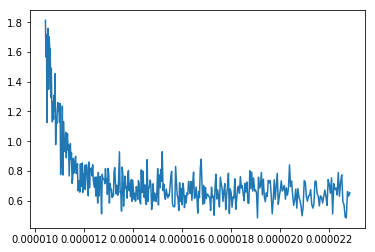

In [66]:
import matplotlib.pyplot as plt 
plt.plot(np.power(10, lr_callback.lrs[20:400]), lr_callback.losses[20:400])
plt.show()

In [61]:
tf.keras.backend.set_value(model.optimizer.lr, 0.001*0.2)

clr = OneCycle(lr_range=(0.001*0.05, 0.001*0.1),
               momentum_range=(0.9, 0.8))

In [62]:
model.fit(word_seq_train, y_train, validation_data=(word_seq_val, y_val),
           batch_size=450, epochs=1, verbose=1, callbacks=[clr])

# model.fit_generator(train_generator, validation_data=val_generator, steps_per_epoch=int(len(word_seq_train)/batch_size), validation_steps=int(len(word_seq_val)/batch_size), verbose=1)

Train on 15999998 samples, validate on 4000000 samples
Instructions for updating:
Use tf.cast instead.
15999998/15999998 [==============================] - 7012s 438us/sample - loss: 0.5951 - sparse_categorical_accuracy: 0.8671 - val_loss: 0.5702 - val_sparse_categorical_accuracy: 0.8736


In [63]:
#loss: 0.6197 - sparse_categorical_accuracy: 0.8631 - val_loss: 0.5577 - val_sparse_categorical_accuracy: 0.8750 prelu + la
#loss: 0.6337 - sparse_categorical_accuracy: 0.8605 - val_loss: 0.5601 - val_sparse_categorical_accuracy: 0.8747

#loss: 0.5881 - sparse_categorical_accuracy: 0.8678 - val_loss: 0.5573 - val_sparse_categorical_accuracy: 0.8749 adam
calculate_balanced_accuracy_chunks(model, word_seq_val, y_val) #0.8505 prelu + la, 0.8528 mish + la, 0.8528 adam

0.8501058605660863

In [65]:
# save_model(model, 'vec3')
# load_model(model, 'vec3')

In [63]:
tf.keras.backend.set_value(model.optimizer.lr, 0.000014)

In [64]:
# clr = OneCycle(lr_range=(0.001*0.05*0.5, 0.001*0.1*0.5),
#                momentum_range=(0.8, 0.7))

model.fit(word_seq_train, y_train, validation_data=(word_seq_val, y_val),
           batch_size=400, epochs=1, verbose=1)

Train on 15999998 samples, validate on 4000000 samples
Instructions for updating:
Use tf.cast instead.
15999998/15999998 [==============================] - 7280s 455us/sample - loss: 0.5186 - sparse_categorical_accuracy: 0.8818 - val_loss: 0.5612 - val_sparse_categorical_accuracy: 0.8756


In [65]:
#loss: 0.5019 - sparse_categorical_accuracy: 0.8844 - val_loss: 0.5296 - val_sparse_categorical_accuracy: 0.8810 prelu + la
calculate_balanced_accuracy_chunks(model, word_seq_val, y_val) #0.8590, 0.8593 mish + la

0.8528503700461636

In [72]:
# save_model(model, 'vec3')
# load_model(model, 'vec3') #seguir desde aca

In [65]:
# tf.keras.backend.set_value(model.optimizer.lr, 0.0003*0.5*0.2)
model.fit(word_seq_train, y_train, validation_data=(word_seq_val, y_val),
           batch_size=1200, epochs=1, verbose=1)

Train on 15999998 samples, validate on 4000000 samples
Instructions for updating:
Use tf.cast instead.
15999998/15999998 [==============================] - 4793s 300us/sample - loss: 0.4337 - sparse_categorical_accuracy: 0.8971 - val_loss: 0.5312 - val_sparse_categorical_accuracy: 0.8818


In [66]:
#loss: 0.4526 - sparse_categorical_accuracy: 0.8938 - val_loss: 0.5213 - val_sparse_categorical_accuracy: 0.8833, prelu + lookahead
calculate_balanced_accuracy_chunks(model, word_seq_val, y_val) # 0.8592 antes, 0.8622 prelu + lookahead

0.8622008960485829

In [63]:
# save_model(model, 'vec3')
# load_model(model, 'vec3')

In [67]:
tf.keras.backend.set_value(model.optimizer.lr, tf.keras.backend.get_value(model.optimizer.lr)*0.3)
model.fit(word_seq_train, y_train, validation_data=(word_seq_val, y_val),
           batch_size=1024, epochs=1, verbose=1)

Train on 15999998 samples, validate on 4000000 samples
15999998/15999998 [==============================] - 4006s 250us/sample - loss: 0.4506 - sparse_categorical_accuracy: 0.8941 - val_loss: 0.5228 - val_sparse_categorical_accuracy: 0.8830


In [68]:
calculate_balanced_accuracy_chunks(model, word_seq_val, y_val)

0.8627204686986996

In [44]:
#modelo word_embeddings:

# 0.8472 val - 0.8852 test
# 0.8545 val - 0.8869 test
# 0.8592 val - 0.8915 test
# 0.8625 val - 0.8944 test

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(max_features=int(MAX_NB_WORDS/2))
tfidf_vect.fit(df['title'].values.astype('U'))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=60000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [21]:
tfidf_vect.vocabulary_

{'hidrolavadora': 31008,
 'one': 41806,
 '120': 979,
 'bar': 12773,
 '1700w': 1968,
 'bomba': 14262,
 'aluminio': 10047,
 'italia': 32950,
 'placa': 44555,
 'sonido': 51911,
 'behringer': 13257,
 'umc22': 56454,
 'maquina_pt': 37189,
 'lavar_pt': 35005,
 'electrolux_pt': 24038,
 '12_pt': 1161,
 'kilos_pt': 34143,
 'par_pt': 42837,
 'disco_pt': 22420,
 'freio': 27927,
 'diant': 22128,
 'vent_pt': 57394,
 'gol_pt': 29497,
 '8v_pt': 7953,
 '08': 283,
 'fremax': 27931,
 'flashes': 27231,
 'led': 35113,
 'pestanas': 43925,
 'luminoso': 36309,
 'falso': 26349,
 'partido': 43009,
 '4_pt': 5427,
 'microaspersor': 38415,
 'irrigacao': 32865,
 'ultra_pt': 56383,
 '20_pt': 2775,
 'metros_pt': 38309,
 'raquete': 47182,
 'clash_pt': 18249,
 '100_pt': 451,
 'tour_pt': 55246,
 '_pt': 8365,
 'nova_pt': 41146,
 'kit_pt': 34203,
 'tripe_pt': 55828,
 'celular_pt': 17156,
 'camera_pt': 15939,
 '20m_pt': 2812,
 'brinde_pt': 14860,
 'nf': 40761,
 'filtro_pt': 26965,
 'ar_pt': 11069,
 'bonanza_pt': 14305,
 '

In [26]:
save_object(tfidf_vect, 'tfidf_vect')

In [51]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)',text) ]

In [33]:
filenames = [f for f in listdir(path+'large')]
filenames.sort(key=natural_keys)
epochs = 1
len_data = 1000000
decay = 1
best_balanced_accuracy = 0

for _ in range(epochs):
    iter_num = 0
    
#     clr = CyclicLR(base_lr=0.001*decay, max_lr=0.002*decay, step_size=20000., mode='triangular2')
    tf.keras.backend.set_value(model.optimizer.lr, 0.001*0.2)
    
    for filename in filenames:
        print(filename)
        labels = df['category'].iloc[iter_num*len_data : (iter_num+1)*len_data]
        X_train, X_val, y_train, y_val = get_data(path + '/large/' + filename, labels, encoderCat, test_size=0.1)
        
        print('lr before: ' + str(tf.keras.backend.get_value(model.optimizer.lr)))
        
        model.fit(X_train, y_train, validation_data=(X_val, y_val),
               batch_size=256, epochs=1, verbose=1,)# callbacks=[clr])
        
        print('lr after: ' + str(tf.keras.backend.get_value(model.optimizer.lr)))
        balanced_accuracy = calculate_balanced_accuracy(X_val, y_val)
        print('balanced_accuracy: ' + str(balanced_accuracy))
        
        if balanced_accuracy > best_balanced_accuracy:
            best_balanced_accuracy = balanced_accuracy
        else:
            tf.keras.backend.set_value(model.optimizer.lr, tf.keras.backend.get_value(model.optimizer.lr)*0.5)
        
        del X_train, X_val, y_train, y_val
        gc.collect()

        iter_num += 1
        
    decay = decay*0.2
    tf.keras.backend.set_value(model.optimizer.lr, tf.keras.backend.get_value(model.optimizer.lr)*decay)

encodings_3_layers_0.npy
lr before: 0.0002
Train on 900000 samples, validate on 100000 samples
900000/900000 [==============================] - 1074s 1ms/sample - loss: 0.9977 - sparse_categorical_accuracy: 0.8001 - val_loss: 0.8735 - val_sparse_categorical_accuracy: 0.8239
lr after: 0.0002
balanced_accuracy: 0.7878131573558538
encodings_3_layers_1.npy
lr before: 0.0002
Train on 900000 samples, validate on 100000 samples
900000/900000 [==============================] - 1083s 1ms/sample - loss: 0.9617 - sparse_categorical_accuracy: 0.8064 - val_loss: 0.8439 - val_sparse_categorical_accuracy: 0.8290
lr after: 0.0002
balanced_accuracy: 0.7945393969624746
encodings_3_layers_2.npy
lr before: 0.0002
Train on 900000 samples, validate on 100000 samples
900000/900000 [==============================] - 1089s 1ms/sample - loss: 0.9340 - sparse_categorical_accuracy: 0.8116 - val_loss: 0.8435 - val_sparse_categorical_accuracy: 0.8289
lr after: 0.0002
balanced_accuracy: 0.7977145227319922
encodings_

KeyboardInterrupt: 

In [30]:
# tf.keras.backend.set_value(model.optimizer.lr, 0.001*0.2)
# tf.keras.backend.get_value(model.optimizer.lr)

In [32]:
# model.save('model2')
# model.save_weights('model_weights2')
# model.load_weights('model_weights2')

In [ ]:
# triangular: (max_lr=0.003, Adam)
# it 8: 0.718 60k step_size, 0.707 30k step_size, 0.722 20k step_size, 0.7154 10k step_size 
# it 12:                     0.737 30k step_size, 0.754 20k step_size, 0.7515 10k step_size
# it 19:                                          0.738 20k step_size

# triangular2:

# it 8:  0.723 20k step
# it 12: 0.752 20k step
# it 19: 0.752 20k step

In [8]:
#0.6752 val - 0.709 test
#0.7335 val - 0.770 test
#0.7540 val - 0.794 test
#0.7793 val - 0.819 test
#0.7850 val - 0.823 test
#0.8136 val - 0.838 test

In [6]:
# df_test = pd.read_csv(path + 'test.csv')
# bc = BertClient()
# titles = df_test['title'].str.lower().values.tolist()
# encodings = bc.encode(titles)
# np.save('/media/axel/ssd/ml-challenge/encodings_test', encodings)

In [24]:
# encodingsTest = np.load('/media/axel/ssd/ml-challenge/encodings_test.npy')
# encodingsTest = np.expand_dims(encodingsTest, 2)

In [66]:
y_preds_chunks = np.array([])

num_models = 50
for chunk in chunks(word_seq_test, int(50000/num_models)):
    y_probas = np.stack([model.predict(chunk) for sample in range(num_models)])
    y_proba = y_probas.mean(axis=0)
    y_proba = np.argmax(y_proba, axis=-1)
    y_preds_chunks = np.append(y_preds_chunks, y_proba)
    del y_probas
    gc.collect()

In [67]:
y_pred = y_preds.astype(int)

In [62]:
# del y_preds
# gc.collect()

In [60]:
# y_pred = model.predict(encodingsTest)
y_pred = model.predict(word_seq_test)
y_pred = np.argmax(y_pred, axis=-1)

In [61]:
y_pred = encoderCat.inverse_transform(y_pred)

In [62]:
df_sub = pd.read_csv('sample_submission.csv')

In [63]:
df_sub['category'] = y_pred

In [64]:
df_sub.to_csv('../../sub.csv', index=False)